<a href="https://colab.research.google.com/github/VivekSaini11/AI-Capstone-Project/blob/master/E_commerce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Problem Statement**

Amazon is an online shopping website that now caters to millions of people everywhere. Over 34,000 consumer reviews for Amazon brand products like Kindle, Fire TV Stick and more are provided. 
The dataset has attributes like brand, categories, primary categories, reviews.title, reviews.text, and the sentiment. Sentiment is a categorical variable with three levels "Positive", "Negative“, and "Neutral". For a given unseen data, the sentiment needs to be predicted.
You are required to predict Sentiment or Satisfaction of a purchase based on multiple features and review text.

In [59]:
import re
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [9]:
header_list = ["name", "brand", "categories", "primaryCategories", "reviews.date", "reviews.text", "reviews.title", "sentiment"]
train = pd.read_csv("train_data.csv", names=header_list)
train

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment
0,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment
1,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2016-12-26T00:00:00.000Z,Purchased on Black FridayPros - Great Price (e...,Powerful tablet,Positive
2,Amazon - Echo Plus w/ Built-In Hub - Silver,Amazon,"Amazon Echo,Smart Home,Networking,Home & Tools...","Electronics,Hardware",2018-01-17T00:00:00.000Z,I purchased two Amazon in Echo Plus and two do...,Amazon Echo Plus AWESOME,Positive
3,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Amazon Echo,Virtual Assistant Speakers,Electro...","Electronics,Hardware",2017-12-20T00:00:00.000Z,Just an average Alexa option. Does show a few ...,Average,Neutral
4,"Fire HD 10 Tablet, 10.1 HD Display, Wi-Fi, 16 ...",Amazon,"eBook Readers,Fire Tablets,Electronics Feature...","Office Supplies,Electronics",2017-08-04T00:00:00.000Z,"very good product. Exactly what I wanted, and ...",Greattttttt,Positive
...,...,...,...,...,...,...,...,...
3996,Amazon - Echo Plus w/ Built-In Hub - Silver,Amazon,"Amazon Echo,Smart Home,Networking,Home & Tools...","Electronics,Hardware",2017-12-08T00:00:00.000Z,"It‚Äôs fun for the family to play with, but it...",Fun toy,Positive
3997,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",Amazon,"Computers,Electronics Features,Tablets,Electro...",Electronics,2017-03-31T00:00:00.000Z,"I love the Kindle, it is a great product. It r...",Great Product,Positive
3998,Amazon Tap - Alexa-Enabled Portable Bluetooth ...,Amazon,"Amazon Echo,Home Theater & Audio,MP3 MP4 Playe...",Electronics,2017-01-19T00:00:00.000Z,I was looking for a blutooth speaker to use wi...,"Great ""dumb"" speaker",Positive
3999,"Brand New Amazon Kindle Fire 16gb 7"" Ips Displ...",Amazon,"Computers/Tablets & Networking,Tablets & eBook...",Electronics,2016-05-27T00:00:00.000Z,This is the second Amazon Fire 7 tablet I have...,A great 7 inch tablet at a great price,Positive


In [10]:
test = pd.read_csv('test_data.csv') 
test

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title
0,"Fire Tablet, 7 Display, Wi-Fi, 16 GB - Include...",Amazon,"Fire Tablets,Computers/Tablets & Networking,Ta...",Electronics,2016-05-23T00:00:00.000Z,Amazon kindle fire has a lot of free app and c...,very handy device
1,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Computers,Amazon Echo,Virtual Assistant Speake...","Electronics,Hardware",2018-01-02T00:00:00.000Z,The Echo Show is a great addition to the Amazo...,Another winner from Amazon
2,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2017-01-02T00:00:00.000Z,Great value from Best Buy. Bought at Christmas...,simple to use and reliable so far
3,"Brand New Amazon Kindle Fire 16gb 7"" Ips Displ...",Amazon,"Computers/Tablets & Networking,Tablets & eBook...",Electronics,2017-03-25T00:00:00.000Z,"I use mine for email, Facebook ,games and to g...",Love it!!!
4,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Computers,Amazon Echo,Virtual Assistant Speake...","Electronics,Hardware",2017-11-15T00:00:00.000Z,This is a fantastic item & the person I bought...,Fantastic!
...,...,...,...,...,...,...,...
995,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Computers,Amazon Echo,Virtual Assistant Speake...","Electronics,Hardware",2017-12-07T18:06:07.000Z,We love Alexa! Love being able to watch news b...,Awesome
996,Amazon Tap - Alexa-Enabled Portable Bluetooth ...,Amazon,"Amazon Echo,Home Theater & Audio,MP3 MP4 Playe...",Electronics,2017-01-23T00:00:00.000Z,Speaker is pretty loud and I love that I can t...,Good Bluetooth device
997,"Fire HD 8 Tablet with Alexa, 8"" HD Display, 32...",Amazon,"Tablets,Fire Tablets,Computers & Tablets,All T...",Electronics,2017-01-18T00:00:00.000Z,Bought 2 of these for my 6 and 8 yr old and it...,good product for kids
998,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2016-12-12T00:00:00.000Z,Was told by sales person I could come back in ...,Was misled on price match. Item is okay.


In [11]:
test_hidden = pd.read_csv('test_data_hidden.csv') 
test_hidden

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment
0,"Fire Tablet, 7 Display, Wi-Fi, 16 GB - Include...",Amazon,"Fire Tablets,Computers/Tablets & Networking,Ta...",Electronics,2016-05-23T00:00:00.000Z,Amazon kindle fire has a lot of free app and c...,very handy device,Positive
1,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Computers,Amazon Echo,Virtual Assistant Speake...","Electronics,Hardware",2018-01-02T00:00:00.000Z,The Echo Show is a great addition to the Amazo...,Another winner from Amazon,Positive
2,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2017-01-02T00:00:00.000Z,Great value from Best Buy. Bought at Christmas...,simple to use and reliable so far,Positive
3,"Brand New Amazon Kindle Fire 16gb 7"" Ips Displ...",Amazon,"Computers/Tablets & Networking,Tablets & eBook...",Electronics,2017-03-25T00:00:00.000Z,"I use mine for email, Facebook ,games and to g...",Love it!!!,Positive
4,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Computers,Amazon Echo,Virtual Assistant Speake...","Electronics,Hardware",2017-11-15T00:00:00.000Z,This is a fantastic item & the person I bought...,Fantastic!,Positive
...,...,...,...,...,...,...,...,...
995,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Computers,Amazon Echo,Virtual Assistant Speake...","Electronics,Hardware",2017-12-07T18:06:07.000Z,We love Alexa! Love being able to watch news b...,Awesome,Positive
996,Amazon Tap - Alexa-Enabled Portable Bluetooth ...,Amazon,"Amazon Echo,Home Theater & Audio,MP3 MP4 Playe...",Electronics,2017-01-23T00:00:00.000Z,Speaker is pretty loud and I love that I can t...,Good Bluetooth device,Neutral
997,"Fire HD 8 Tablet with Alexa, 8"" HD Display, 32...",Amazon,"Tablets,Fire Tablets,Computers & Tablets,All T...",Electronics,2017-01-18T00:00:00.000Z,Bought 2 of these for my 6 and 8 yr old and it...,good product for kids,Positive
998,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2016-12-12T00:00:00.000Z,Was told by sales person I could come back in ...,Was misled on price match. Item is okay.,Positive


Class Imbalance Problem

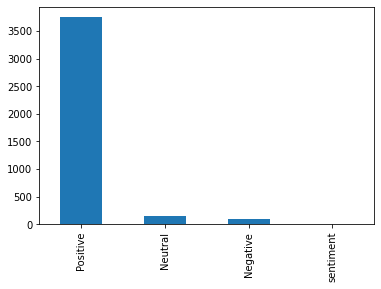

In [12]:
#  See what a positive, negative, and neutral review looks like
train['sentiment'].value_counts().plot(kind="bar")

In [13]:
# Check the class count for each class. It’s a class imbalance problem.
train['sentiment'].value_counts()

Positive     3749
Neutral       158
Negative       93
sentiment       1
Name: sentiment, dtype: int64

In [14]:
# Convert the reviews in Tf-Idf score.
tfidf = TfidfVectorizer(analyzer='char',ngram_range=(2,3),token_pattern=r'\w{1,}',max_features=5000)
train_tfidf = tfidf.fit_transform(train['reviews.text'])
test_tfidf = tfidf.fit_transform(test_hidden['reviews.text'])

In [15]:
# Run multinomial Naive Bayes classifier. Everything will be classified as positive because of the class imbalance
nb = MultinomialNB()
%time nb.fit(train_tfidf, train['sentiment'])
y_pred_class = nb.predict(test_tfidf)

CPU times: user 22.7 ms, sys: 0 ns, total: 22.7 ms
Wall time: 25.8 ms


In [16]:
train.isnull().sum()

name                  0
brand                 0
categories            0
primaryCategories     0
reviews.date          0
reviews.text          0
reviews.title        10
sentiment             0
dtype: int64

In [17]:
train.dropna(subset = ["reviews.title"], inplace=True)

Tackling Class Imbalance Problem

In [18]:
# Oversampling or undersampling can be used to tackle the class imbalance problem. 
print(Counter(train['sentiment']))
oversample = RandomOverSampler(sampling_strategy='minority')
X_over, y_over = oversample.fit_resample(train.drop(['sentiment'], axis=1), train['sentiment'])
print(Counter(y_over))

Counter({'Positive': 3739, 'Neutral': 158, 'Negative': 93, 'sentiment': 1})
Counter({'sentiment': 3739, 'Positive': 3739, 'Neutral': 158, 'Negative': 93})


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [19]:
df_train = pd.DataFrame(data=X_over, columns=["name", "brand", "categories", "primaryCategories", "reviews.date", "reviews.text", "reviews.title"])

In [20]:
lb_make = LabelEncoder()
y_over= lb_make.fit_transform(y_over)
y_over

array([3, 2, 2, ..., 3, 3, 3])

In [21]:
lb_make = LabelEncoder()
test_hidden['sentiment']= lb_make.fit_transform(test_hidden['sentiment'])
test_hidden['sentiment']

0      2
1      2
2      2
3      2
4      2
      ..
995    2
996    1
997    2
998    2
999    2
Name: sentiment, Length: 1000, dtype: int64

In [22]:
# Convert the reviews in Tf-Idf score.
tfidf = TfidfVectorizer(analyzer='char',ngram_range=(2,3),token_pattern=r'\w{1,}',max_features=5000)
train_tfidf = tfidf.fit_transform(df_train['reviews.text'])
test_tfidf = tfidf.fit_transform(test_hidden['reviews.text'])

In [23]:
# Use Tree-based classifiers like Random Forest and XGBoost.
regressor = RandomForestRegressor(n_estimators=20, random_state=0)
regressor.fit(train_tfidf, y_over)
y_pred_regressor = regressor.predict(test_tfidf)
y_pred_regressor[:10]

array([1.35, 1.7 , 1.35, 1.65, 1.95, 1.6 , 1.35, 1.35, 1.45, 1.35])

In [69]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
grid_search = GridSearchCV(estimator = regressor, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(train_tfidf, y_over)
grid_search.best_params_

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   33.4s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed: 12.6min finished


{'bootstrap': True,
 'max_depth': 80,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 1000}

In [24]:
# Use Tree-based classifiers like Random Forest and XGBoost.
model = XGBClassifier()
model.fit(train_tfidf, y_over)
y_pred_xgbost = model.predict(test_tfidf)
y_pred_xgbost[:10]

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [25]:
# precision, recall, F1-score, AUC-ROC curve. Use F1-Score for Xgboost
accuracy = accuracy_score(test_hidden['sentiment'], y_pred_xgbost)
print('Accuracy: %f' % accuracy)
precision = precision_score(test_hidden['sentiment'], y_pred_xgbost, average='micro')
print('Precision: %f' % precision)
recall = recall_score(test_hidden['sentiment'], y_pred_xgbost, average='micro')
print('Recall: %f' % recall)
f1 = f1_score(test_hidden['sentiment'], y_pred_xgbost, average='micro')
print('F1 score: %f' % f1)

Accuracy: 0.935000
Precision: 0.935000
Recall: 0.935000
F1 score: 0.935000


In [26]:
# precision, recall, F1-score, AUC-ROC curve. Use F1-Score for Random Forest
accuracy = accuracy_score(test_hidden['sentiment'], y_pred_regressor.astype('int'))
print('Accuracy: %f' % accuracy)
precision = precision_score(test_hidden['sentiment'],  y_pred_regressor.astype('int'), average='micro')
print('Precision: %f' % precision)
recall = recall_score(test_hidden['sentiment'],  y_pred_regressor.astype('int'), average='micro')
print('Recall: %f' % recall)
f1 = f1_score(test_hidden['sentiment'],  y_pred_regressor.astype('int'), average='micro')
print('F1 score: %f' % f1)

Accuracy: 0.040000
Precision: 0.040000
Recall: 0.040000
F1 score: 0.040000


In [49]:
#Create a svm Classifier
clf = SVC(kernel='linear') # Linear Kernel
clf.fit(train_tfidf, y_over)
y_pred_svm = clf.predict(test_tfidf)
y_pred_svm[:10]

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [50]:
# precision, recall, F1-score, AUC-ROC curve. Use F1-Score for SVM
accuracy = accuracy_score(test_hidden['sentiment'], y_pred_svm)
print('Accuracy: %f' % accuracy)
precision = precision_score(test_hidden['sentiment'],  y_pred_svm, average='micro')
print('Precision: %f' % precision)
recall = recall_score(test_hidden['sentiment'],  y_pred_svm, average='micro')
print('Recall: %f' % recall)
f1 = f1_score(test_hidden['sentiment'],  y_pred_svm, average='micro')
print('F1 score: %f' % f1)

Accuracy: 0.937000
Precision: 0.937000
Recall: 0.937000
F1 score: 0.937000


In [34]:
# Use LSTM for the previous problem (use parameters of LSTM like top-word, embedding-length, Dropout, epochs, number of layers, etc.)
train['reviews.text'] = train['reviews.text'].str.lower()
tokenizer = Tokenizer(num_words=1500, split=' ')
tokenizer.fit_on_texts(train['reviews.text'].values)
X_train = tokenizer.texts_to_sequences(train['reviews.text'])
X_train = pad_sequences(X_train)

test_hidden['reviews.text'] = test_hidden['reviews.text'].str.lower()
tokenizer = Tokenizer(num_words=1500, split=' ')
tokenizer.fit_on_texts(test_hidden['reviews.text'].values)
X_test = tokenizer.texts_to_sequences(test_hidden['reviews.text'])
X_test = pad_sequences(X_test)
X_test

array([[   0,    0,    0, ...,   57,  297,  550],
       [   0,    0,    0, ...,  103,  122,  485],
       [   0,    0,    0, ...,   50,  113,  213],
       ...,
       [   0,    0,    0, ...,   82,    1,  607],
       [   0,    0,    0, ...,  214,    8, 1386],
       [   0,    0,    0, ...,   78,    3,  424]], dtype=int32)

In [35]:
Le = LabelEncoder()
Y_train = Le.fit_transform(train['sentiment'])
y_test = Le.fit_transform(test_hidden['sentiment'])
y_test

array([2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2,

In [44]:
embed_dim = 128
lstm_out = 196
max_fatures = 2000
model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X_train.shape[1]))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
model.fit(X_train, Y_train,validation_data = (X_test,y_test),epochs = 5, batch_size=100)
model.evaluate(X_test,y_test)

Epoch 1/5
40/40 [==============================] - 604s 15s/step - loss: 0.6932 - accuracy: 0.0303 - val_loss: 0.6931 - val_accuracy: 0.0350
Epoch 2/5
40/40 [==============================] - 605s 15s/step - loss: 0.6931 - accuracy: 0.0298 - val_loss: 0.6931 - val_accuracy: 0.0320
Epoch 3/5
40/40 [==============================] - 605s 15s/step - loss: 0.6931 - accuracy: 0.0353 - val_loss: 0.6931 - val_accuracy: 0.0390
Epoch 4/5
40/40 [==============================] - 602s 15s/step - loss: 0.6931 - accuracy: 0.0303 - val_loss: 0.6931 - val_accuracy: 0.0350
Epoch 5/5
32/32 [==============================] - 30s 940ms/step - loss: 0.6931 - accuracy: 0.0340


[0.6931471228599548, 0.03400000184774399]

In [46]:
print("Prediction: ",model.predict_classes(X_test[5:10]))
print("Actual: \n",y_test[5:10])

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Prediction:  [0 1 1 1 1]
Actual: 
 [2 2 0 2 2]


Topic Modeling

In [52]:
# Use scikit-learn provided Latent Dirchlette Allocation (LDA)
cv = CountVectorizer(max_df = 0.95, min_df = 2, stop_words = 'english')
df = cv.fit_transform(train['reviews.text'])
lda = LatentDirichletAllocation(n_components = 7, random_state = 42)
lda.fit(df)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=7, n_jobs=None,
                          perp_tol=0.1, random_state=42, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [53]:
for index, topic in enumerate(lda.components_):
    print(f'Top 15 words for Topic #{index}')
    print([cv.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

Top 15 words for Topic #0
['price', 'grandson', 'purchased', 'gift', 'son', 'kids', 'daughter', 'love', 'games', 'year', 'bought', 'old', 'tablet', 'loves', 'great']


Top 15 words for Topic #1
['speaker', 'screen', 'plus', 'video', 'like', 'smart', 'amazon', 'sound', 'use', 'home', 'love', 'music', 'great', 'alexa', 'echo']


Top 15 words for Topic #2
['love', 'life', 'really', 'size', 'book', 'light', 'like', 'reading', 'battery', 'just', 'screen', 'good', 'books', 'kindle', 'read']


Top 15 words for Topic #3
['know', 'app', 'tablets', 'time', 'buy', 'prime', 'use', 'apps', 'best', 'device', 'love', 'bought', 'kids', 'tablet', 'amazon']


Top 15 words for Topic #4
['better', 'little', 'got', 'christmas', 'works', 'like', 'bought', 'amazon', 'gift', 'recommend', 'price', 'good', 'product', 'great', 'tablet']


Top 15 words for Topic #5
['perfect', 'amazon', 'need', 'good', 'bought', 'play', 'product', 'kids', 'set', 'apps', 'love', 'great', 'tablet', 'use', 'easy']


Top 15 words for

In [57]:
# Use scikit-learn provided Non-Negative Matrix Factorization (NMF)
model_nmf = NMF(n_components=2, init='random', random_state=0)
model_nmf.fit_transform(df)

array([[0.00064713, 0.00204017],
       [0.33187535, 0.        ],
       [0.21425039, 0.02937324],
       ...,
       [0.1958453 , 0.07232311],
       [0.09831357, 0.03032576],
       [0.04561546, 0.        ]])

In [58]:
for index, topic in enumerate(model_nmf.components_):
    print(f'Top 15 words for Topic #{index}')
    print([cv.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

Top 15 words for Topic #0
['love', 'like', 'just', 'home', 'good', 'music', 'app', 'echo', 'apps', 'screen', 'great', 'use', 'device', 'amazon', 'tablet']


Top 15 words for Topic #1
['time', 'easy', 'light', 'battery', 'just', 'äôm', 'cover', 'reading', 'bought', 'book', 'äôt', 'oasis', 'read', 'charge', 'kindle']


